# Area de pruebas

In [1]:
# Carga y procesamiento de datos.
import pandas as pd
import os

def encabezados(df):
    '''
    Renombra las columnas para que estén de acuerdo al estándar 'snake_case'.
    '''
    new_col_names = []
    for name in df.columns:
        name_lowered = name.lower()
        name_stripped = name_lowered.strip()
        name_no_spaces = name_stripped.replace(' ', '_')
        name_string = str(name_no_spaces)
        new_col_names.append(name_string)
    df.columns = new_col_names
    return df

def load_dataset(file_path, file_type='csv', sep=',', encoding='latin1'):
    """
    Carga un dataset desde una ruta de archivo y crea las columnas necesarias para continuar con el análisis.

    Parameters:
        file_path (str): La ruta del archivo.
        file_type (str): Se puede especificar el tipo de archivo ('csv' o 'excel'). El valor por defecto es 'csv'.
        **kwargs: Argumentos adicionales que se pasarán a la función de carga: headers, sep, encoding, etc.

    Returns:
        df: El dataset cargado y con nombres de columnas ajustados desde el archivo.
    """
    try:
        if file_type == 'csv':
            df = pd.read_csv(file_path, sep=sep, encoding=encoding)
        elif file_type == 'excel':
            df = pd.read_excel(file_path, sep=sep, encoding=encoding)
        else:
            print(f"Tipo de archivo {file_type} no soportado.")
            return None
        print(f"Dataset cargado desde {file_path}.")
        df = encabezados(df)
        df['total_cost'] = df['quantity'] * df['unit_price']
        df['invoice_date'] = pd.to_datetime(df['invoice_date'], format="%d/%m/%Y %H:%M")
        df['month'] = df['invoice_date'].dt.month
        df['year'] = df['invoice_date'].dt.year
        print("Encabezados ajustados.")
        print(df.head(10))
        print(df.info())
        return df
    except FileNotFoundError:
        print(f"El archivo {file_path} no se encontró.")
    except pd.errors.EmptyDataError:
        print("El archivo está vacío.")
    except pd.errors.ParserError:
        print("Error al analizar el archivo.")
    except Exception as e:
        print(f"Ocurrió un error: {e}")
        return None

def clear_data(df, columns=['description', 'customer_id'], critic_columns=['quantity', 'unit_price', 'customer_id', 'total_cost']):
    """
    Esta función elimina duplicados explícitos.
    Se pueden seleccionar columnas para rellenar con 'unknown' valores nulos.

    Parameters:
        df : dataset a limpiar.
        critic_columns (list): Lista de columnas que se analizarán para eliminar valores nulos.
        columns (list): Lista de columnas que se analizarán para cambiar valores nulos por 'unknown'.

    Returns:
        df: dataset limpio.
        dict: El número de valores nulos encontrados antes de la limpieza.
    """
    if df is None:
        print("El DataFrame está vacío. No se puede proceder con la limpieza de datos.")
        return None, {}
    df = df.drop_duplicates()
    df = df.dropna(subset=critic_columns)
    null_counts = {}
    for column in columns:
        null_count = df[column].isnull().sum()
        null_counts[column] = null_count
        print(f"Valores nulos en la columna '{column}': {null_count}")
        if null_count > 0:
            df[column] = df[column].fillna('unknown')
    return df, null_counts

def remove_outliers(df, column1 = 'quantityt', column2 = 'unit_price'):
    """
    Elimina outliers de una columna específica del DataFrame.

    Parameters:
        df: El DataFrame que se va a modificar.
        column (str): El nombre de la columna de la que se eliminarán los outliers.

    Returns:
        pd.DataFrame: El DataFrame sin outliers en la columna especificada.
    """
    Q1 = df[column1].quantile(0.25)
    Q3 = df[column1].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column1] >= lower_bound) & (df[column1] <= upper_bound)]
    return df
    Q1 = df[column2].quantile(0.25)
    Q3 = df[column2].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column2] >= lower_bound) & (df[column2] <= upper_bound)]
    return df

def clean_data(df, column1= 'quantity', column2= 'unit_price'):
    """
    Limpia el dataset eliminando duplicados, filas con valores nulos en las columnas críticas y outliers.

    Parameters:
        df: El datasert que se va a limpiar.

    Returns:
        df: El dataset limpio.
    """

    # Eliminar filas con unit_price igual a 0.0
    df = df[df['unit_price'] != 0.0]

    # Eliminar duplicados
    df = df.drop_duplicates()

    # Eliminar filas con valores nulos en las columnas críticas
    df = df.dropna(subset=['quantity', 'unit_price', 'customer_id', 'total_cost'])

    # Eliminar outliers
    df = remove_outliers(df, column1)
    df = remove_outliers(df, column2)

    return df

def categorize_transaction(df, column1='stock_code', column2='quantity'):
    """
    Función que categoriza dependiendo de la columna seleccionada para evaluar el tipo de operación: otros, ventas, devoluciones.

    Parameters:
        df: El dataset que se va a modificar.
        column1 (str): El nombre de la columna que se va a evaluar, tiene como valor por defecto 'stock_code'.
        column2 (str): El nombre de la columna que se va a evaluar, tiene como valor por defecto 'quantity'.

    Returns:
        pd.DataFrame: El DataFrame con la nueva columna 'transaction_type' que indica la categoría de la operación.
    """
    if df is None:
        print("El DataFrame está vacío. No se puede proceder con la categorización de transacciones.")
        return None

    categorias_especificas = ['amazonfee', 'post', 's', 'pads', 'cruk', 'dcgssgirl', 'm', 'd', 'dot']

    def categorize(row):
        stock_code = row[column1]
        quantity = row[column2]
        if stock_code in categorias_especificas:
            return 'otros'
        elif quantity > 0:
            return 'ventas'
        elif quantity < 0:
            return 'devoluciones'
        else:
            return 'otros'

    df['transaction_type'] = df.apply(categorize, axis=1)
    print(df.head())
    return df

def save_dataset(df, output_path, file_type='csv', **kwargs):
    """
    Guarda un dataset en un archivo.

    Parameters:
        df: El DataFrame que se va a guardar.
        output_path (str): La ruta del archivo de salida.
        file_type (str): El tipo de archivo para guardar ('csv' o 'excel'). El valor por defecto es 'csv'.
    """
    try:
        if file_type == 'csv':
            df.to_csv(output_path, **kwargs)
        elif file_type == 'excel':
            df.to_excel(output_path, **kwargs)
        else:
            print(f"Tipo de archivo {file_type} no soportado.")
        print(f"Dataset guardado en {output_path}.")
    except Exception as e:
        print(f"Ocurrió un error al guardar el archivo: {e}")

def remove_intermediate_files(paths):
    """
    Elimina archivos intermedios.

    Parameters:
        paths (list): lista de rutas de archivos a eliminar.
    """
    for path in paths:
        try:
            os.remove(path)
            print(f"Archivo {path} eliminado.")
        except Exception as e:
            print(f"No se pudo eliminar el archivo {path}: {e}")

def process_dataset(file_path, output_directory, file_type='csv', **kwargs):
    """
    Procesa el dataset desde la carga hasta la limpieza y guarda el resultado final, eliminando archivos intermedios.

    Parameters:
        file_path (str): La ruta del archivo de entrada.
        output_directory (str): El directorio donde se guardarán los archivos de salida.
        file_type (str): El tipo de archivo para guardar ('csv' o 'excel'). El valor por defecto es 'csv'.
        **kwargs: Argumentos adicionales que se pasarán a la función de carga y guardado.

    Returns:
        pd.DataFrame: El DataFrame procesado.
    """
    df = load_dataset(file_path, file_type, **kwargs)
    if df is None:
        return None

    intermediate_paths = []

    # Paso 1: Limpieza de datos
    df, _ = clear_data(df)
    intermediate_path = f"{output_directory}/df_step1.{file_type}"
    save_dataset(df, intermediate_path, file_type, index=False)
    intermediate_paths.append(intermediate_path)

    # Paso 2: Eliminar outliers
    df = clean_data(df)
    intermediate_path = f"{output_directory}/df_step2.{file_type}"
    save_dataset(df, intermediate_path, file_type, index=False)
    intermediate_paths.append(intermediate_path)

    # Paso 3: Categorizar transacciones
    df = categorize_transaction(df)
    intermediate_path = f"{output_directory}/df_step3.{file_type}"
    save_dataset(df, intermediate_path, file_type, index=False)
    intermediate_paths.append(intermediate_path)

    # Guardar el dataset final
    final_path = f"{output_directory}/df_processed.{file_type}"
    save_dataset(df, final_path, file_type, index=False)

    # Eliminar archivos intermedios
    remove_intermediate_files(intermediate_paths)

    return df


In [2]:
# Ejemplo de uso
file_path = 'files/datasets/input/Online_Retail.csv'
output_directory =  'files/datasets/intermediate'
df = process_dataset(file_path, output_directory)

Dataset cargado desde files/datasets/input/Online_Retail.csv.
Encabezados ajustados.
  invoice_no stock_code                          description  quantity  \
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365      71053                  WHITE METAL LANTERN         6   
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
5     536365      22752         SET 7 BABUSHKA NESTING BOXES         2   
6     536365      21730    GLASS STAR FROSTED T-LIGHT HOLDER         6   
7     536366      22633               HAND WARMER UNION JACK         6   
8     536366      22632            HAND WARMER RED POLKA DOT         6   
9     536367      84879        ASSORTED COLOUR BIRD ORNAMENT        32   

         invoice_date  unit_price  customer_id          region  total_cost  \
0 2019-12-01 08:26:00 

In [3]:
# Creación de métricas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def load_dataset(file_path, file_type='csv', sep=',', encoding='latin1'):
    """
    Carga un dataset desde una ruta de archivo.

    Parameters:
        file_path (str): La ruta del archivo.
        file_type (str): Se puede especificar el tipo de archivo ('csv' o 'excel'). El valor por defecto es 'csv'.
        **kwargs: Argumentos adicionales que se pasarán a la función de carga: headers, sep, encoding, etc.

    Returns:
        df: El DataFrame cargado y con nombres de columnas ajustados desde el archivo.
    """
    try:
        if file_type == 'csv':
            df = pd.read_csv(file_path, sep=sep, encoding=encoding)
        elif file_type == 'excel':
            df = pd.read_excel(file_path, sep=sep, encoding=encoding)
        else:
            print(f"Tipo de archivo {file_type} no soportado.")
            return None
        print(f"Dataset cargado desde {file_path}.")
        print("Encabezados ajustados.")
        return df
    except FileNotFoundError:
        print(f"El archivo {file_path} no se encontró.")
    except pd.errors.EmptyDataError:
        print("El archivo está vacío.")
    except pd.errors.ParserError:
        print("Error al analizar el archivo.")
    except Exception as e:
        print(f"Ocurrió un error: {e}")
        return None

def top_months_sales(df, column1='month', column2='total_cost', column3='region'):
    """
    Función para realizar un gráfico que indica los meses con más ventas.

    Parameters:
        df: El dataset que se va a graficar.
        column1 (str): El nombre de la columna que se usa para agrupar tiene como valor por defecto 'month'.
        column2 (str): El nombre de la columna que contiene valores de ventas, tiene como valor por defecto 'total_cost'.

    Returns:
        Gráfico de meses con mayores ventas.
    """
    global_sales = df.groupby(column1)[column2].sum().sort_values()
    sns.set(style='whitegrid')
    plt.figure(figsize=(20, 6))
    sns.barplot(x=global_sales.index, y=global_sales.values, palette='viridis')
    plt.title('Total de Compras por Mes')
    plt.xlabel('Mes')
    plt.ylabel('Total de Compras')
    plt.show()
    return global_sales

def unit_price_volume_relation(df, column1='unit_price', column2='quantity'):
    """
    Función para generar un gráfico de dispersión que muestra la relación entre el precio unitario y el volumen de compra global.

    Parameters:
        df: El dataset que se va a graficar.
        column1 (str): El nombre de la columna que contiene el precio unitario tiene como valor por defecto 'unit_price'.
        column2 (str): El nombre de la columna que contiene el volumen de compra tiene como valor por defecto 'quantity'.

    Returns:
        Gráfico de dispersión que muestra la relación entre el precio unitario y el volumen de compra global.
    """
    global_relation = df.groupby(column1)[column2].sum().reset_index()
    sns.set(style='whitegrid')
    plt.figure(figsize=(20, 6))
    sns.scatterplot(x=column1, y=column2, data=global_relation, hue=column2, palette='viridis', size=column2, sizes=(20, 200))
    plt.title('Relación Precio Unitario / Volumen de Compra')
    plt.xlabel('Precio Unitario')
    plt.ylabel('Volumen de Compra')
    plt.show()
    return global_relation

def returns_by_region(df, column1='transaction_type', label='devoluciones', column2='region'):
    """
    Función que calcula la cantidad de devoluciones por región y devuelve un gráfico de barras con los resultados.

    Parameters:
        df: El dataset que se va a analizar.
        column1 (str): El nombre de la columna que contiene el tipo de transacción tiene como valor por defecto 'transaction_type'.
        label (str): El nombre de la etiqueta que se usará en el gráfico tiene como valor por defecto 'devoluciones'.
        column2 (str): El nombre de la columna que contiene la región tiene como valor por defecto 'region'.

    Returns:
        Gráfico de barras con la cantidad de devoluciones por región.
    """
    returns_df = df[df[column1] == label]
    returns_by_region = returns_df[column2].value_counts().reset_index()
    returns_by_region.columns = ['region', 'count']
    returns_by_region = returns_by_region.sort_values(by='count', ascending = False)
    sns.set(style='whitegrid')
    plt.figure(figsize=(20, 6))
    sns.barplot(x='region', y='count', data=returns_by_region)
    plt.title('Cantidad de Devoluciones por Región')
    plt.xlabel('Región')
    plt.ylabel('Cantidad de Devoluciones')
    plt.xticks(rotation=45)
    plt.show()
    return returns_by_region

def top_regions_sales(df, column1='transaction_type', label='ventas', column2='region'):
    sales_df = df[df[column1] == label]
    sales_df = sales_df[column2].value_counts().reset_index()
    sales_df.columns = ['region', 'count']
    sales_df = sales_df.sort_values(by='count', ascending = False)
    sns.set(style='whitegrid')
    plt.figure(figsize=(20, 6))
    sns.barplot(x='region', y='count', data=sales_df)
    plt.title('Compras por región')
    plt.xlabel('Región')
    plt.ylabel('Cantidad de Compras')
    plt.xticks(rotation=45)
    plt.show()
    return sales_df


def top_products_sales(df, column1='description', column2='quantity'):
    """
    Función para generar un gráfico de barras que muestra los productos de mayor venta a nivel global.

    Parameters:
        df: El dataset que se va a graficar.

    Returns:
        Gráfico de barras que muestra los productos de mayor venta a nivel global.
    """
    global_top_products = df.groupby(column1)[column2].sum().sort_values(ascending=False).head(10)
    sns.set(style='whitegrid')
    plt.figure(figsize=(20, 6))
    sns.barplot(x=global_top_products.values, y=global_top_products.index, palette='viridis')
    plt.title('Top 10 Productos con Mayor Compra')
    plt.xlabel('Cantidad Total')
    plt.ylabel('Producto')
    plt.show()
    return global_top_products

def top_products_returns(df, column1='quantity', column2='description'):
    """
    Función para generar un gráfico de barras que muestra los productos con más devoluciones a nivel global.

    Parameters:
        df: El dataset que se va a graficar.
        column1 (str): El nombre de la columna que contiene la cantidad tiene como valor por defecto 'quantity'.
        column2 (str): El nombre de la columna que contiene el producto tiene como valor por defecto 'description'.

    Returns:
        Gráfico de barras que muestra los productos con más devoluciones a nivel global.
    """
    df_returns = df[df[column1] < 0]
    top_returns = df_returns.groupby(column2)[column1].sum().sort_values().head(10)
    sns.set(style='whitegrid')
    plt.figure(figsize=(20, 6))
    sns.barplot(x=top_returns.values, y=top_returns.index, palette='viridis')
    plt.title('Top 10 Productos con Mayor Devolución')
    plt.xlabel('Cantidad Total')
    plt.ylabel('Producto')
    plt.show()
    return top_returns

def price_by_region(df):
    """
    Función que calcula el precio promedio por región y devuelve un gráfico de barras con los resultados.

    Parameters:
        df: El dataset que se va a analizar.

    Returns:
        Gráfico de barras con el precio promedio por región.
    """
    sns.set(style='whitegrid')
    plt.figure(figsize=(20, 6))
    sns.boxplot(x='region', y='unit_price', data=df, palette='viridis')
    plt.title('Distribución de Precios por Región', fontsize=16)
    plt.xlabel('Región', fontsize=14)
    plt.ylabel('Precio Unitario', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    return None

def create_all_graphs(file_path, file_type='csv', sep=',', encoding='latin1'):
    df = load_dataset(file_path, file_type, sep, encoding)
    if df is not None:
        top_months_sales(df)
        unit_price_volume_relation(df)
        returns_by_region(df)
        top_regions_sales(df)
        top_products_sales(df)
        top_products_returns(df)
        price_by_region(df)
    else:
        print("No se pudieron cargar los datos. No se pueden crear los gráficos.")



Dataset cargado desde files\datasets\intermediate\df_processed.csv.
Encabezados ajustados.


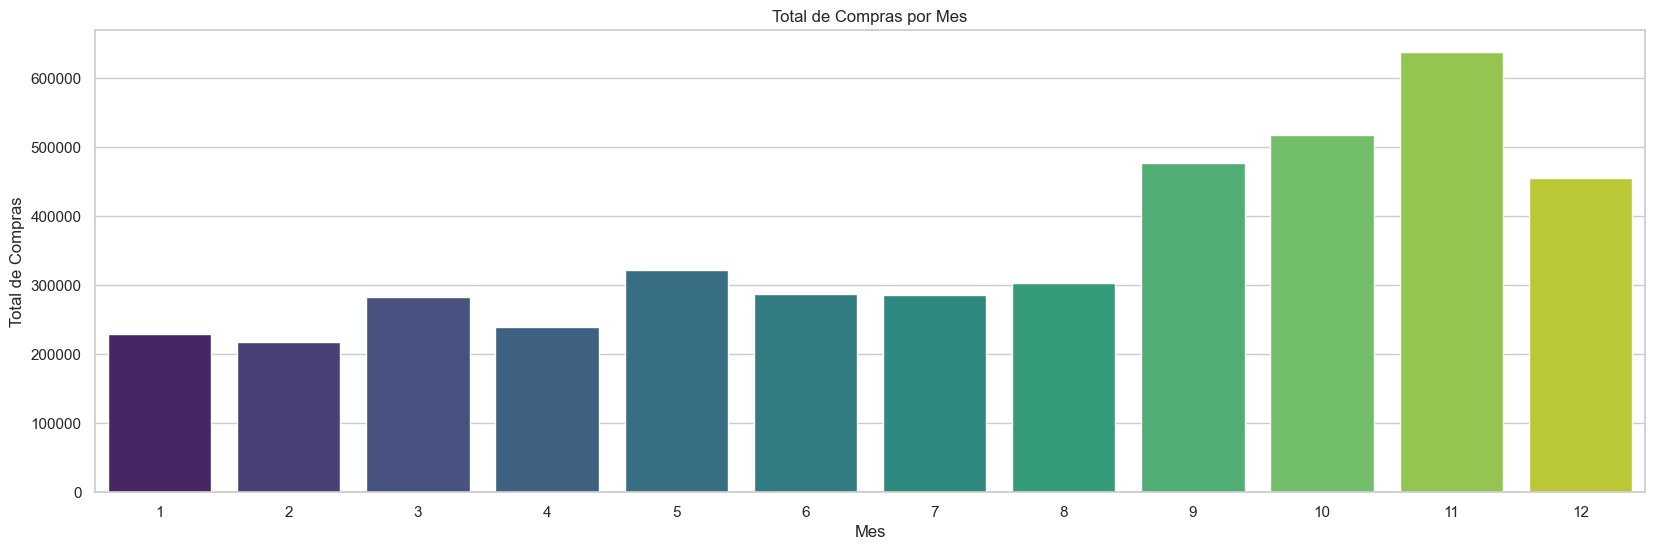

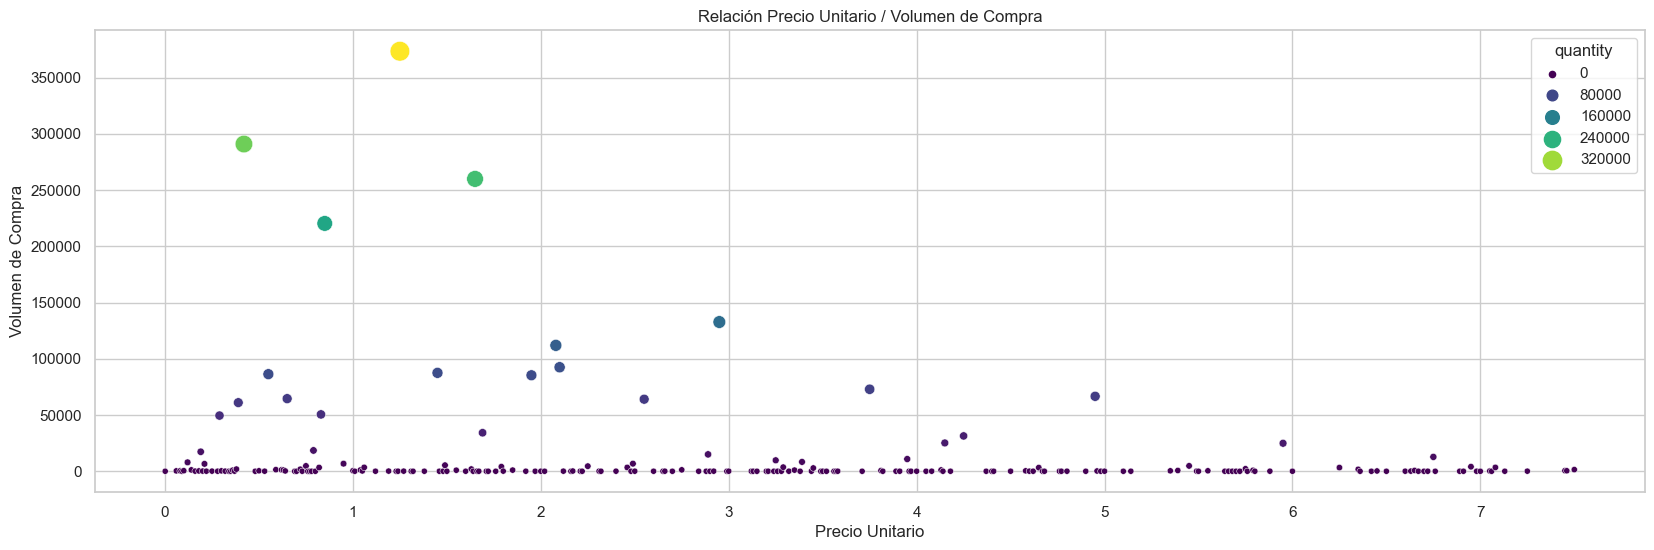

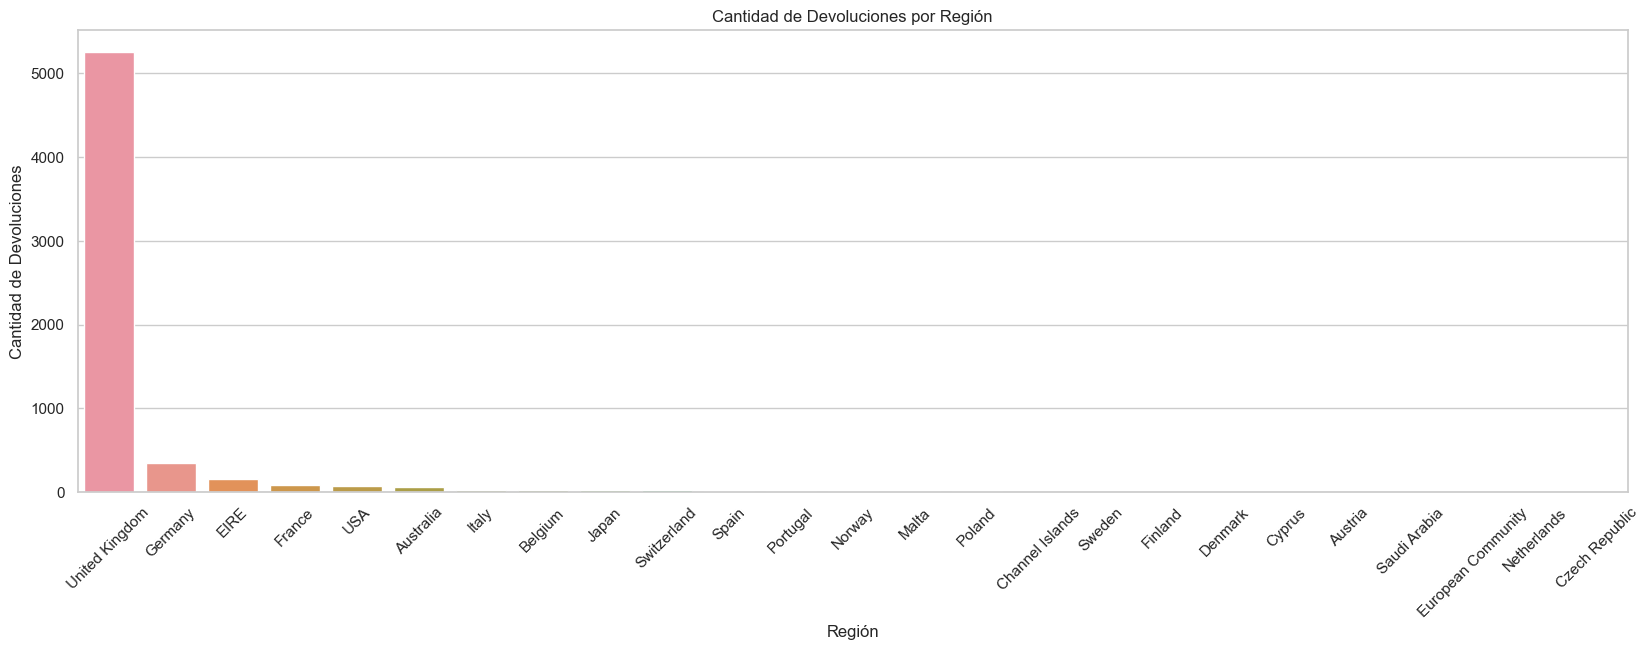

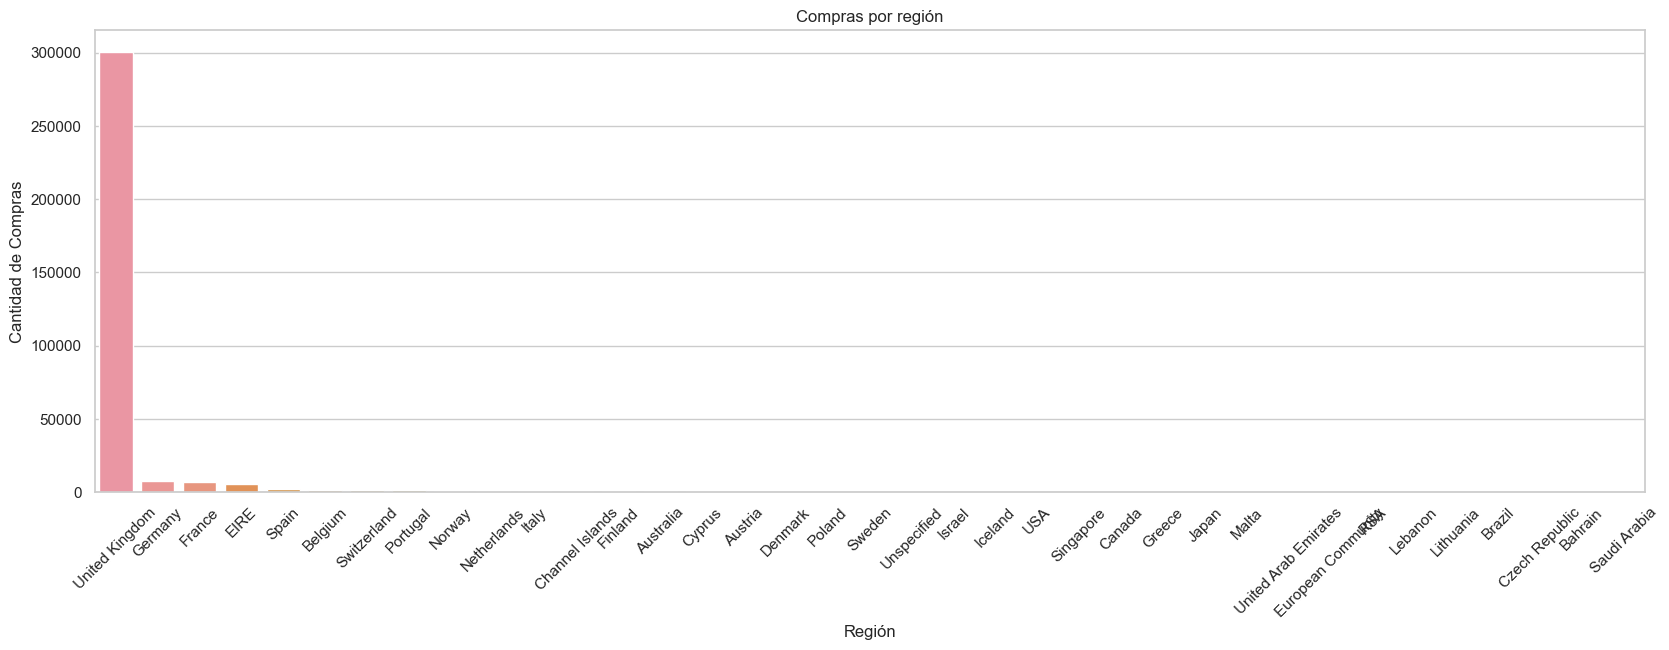

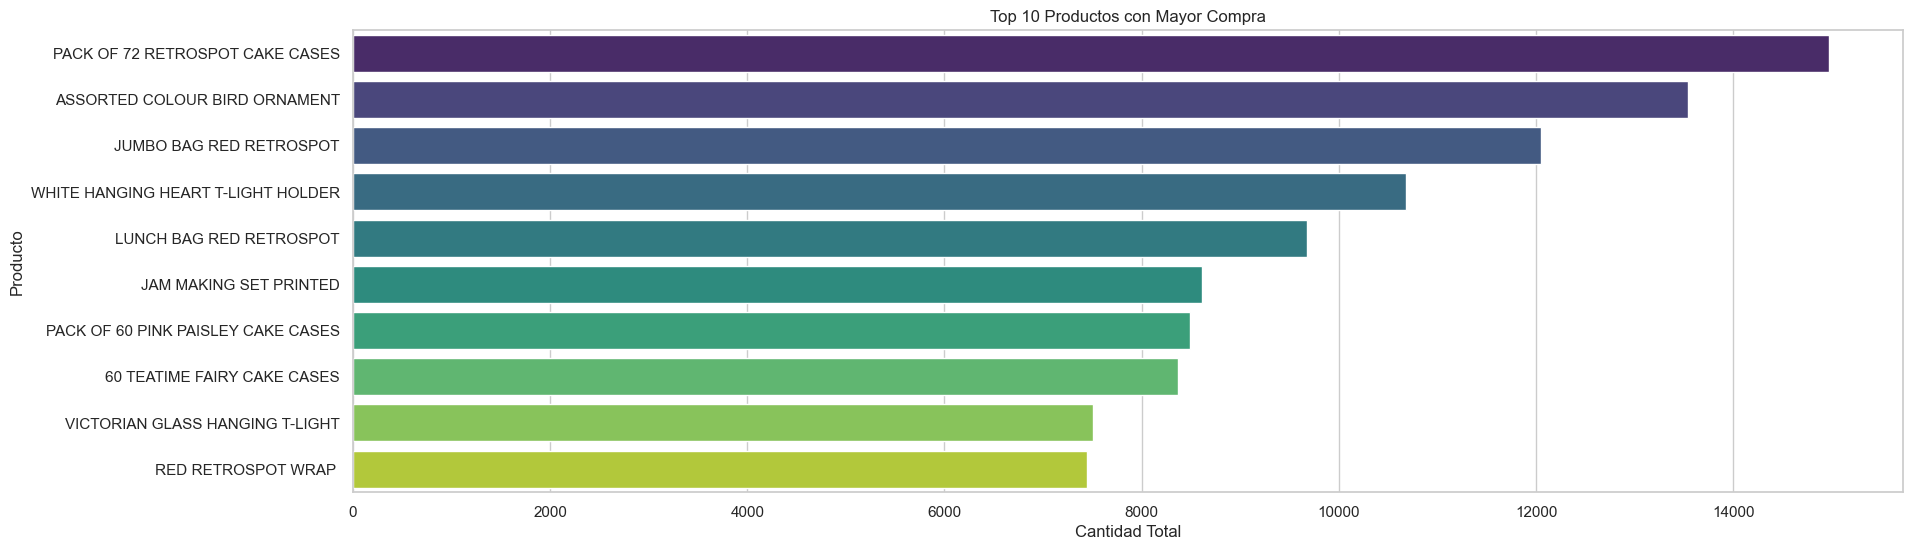

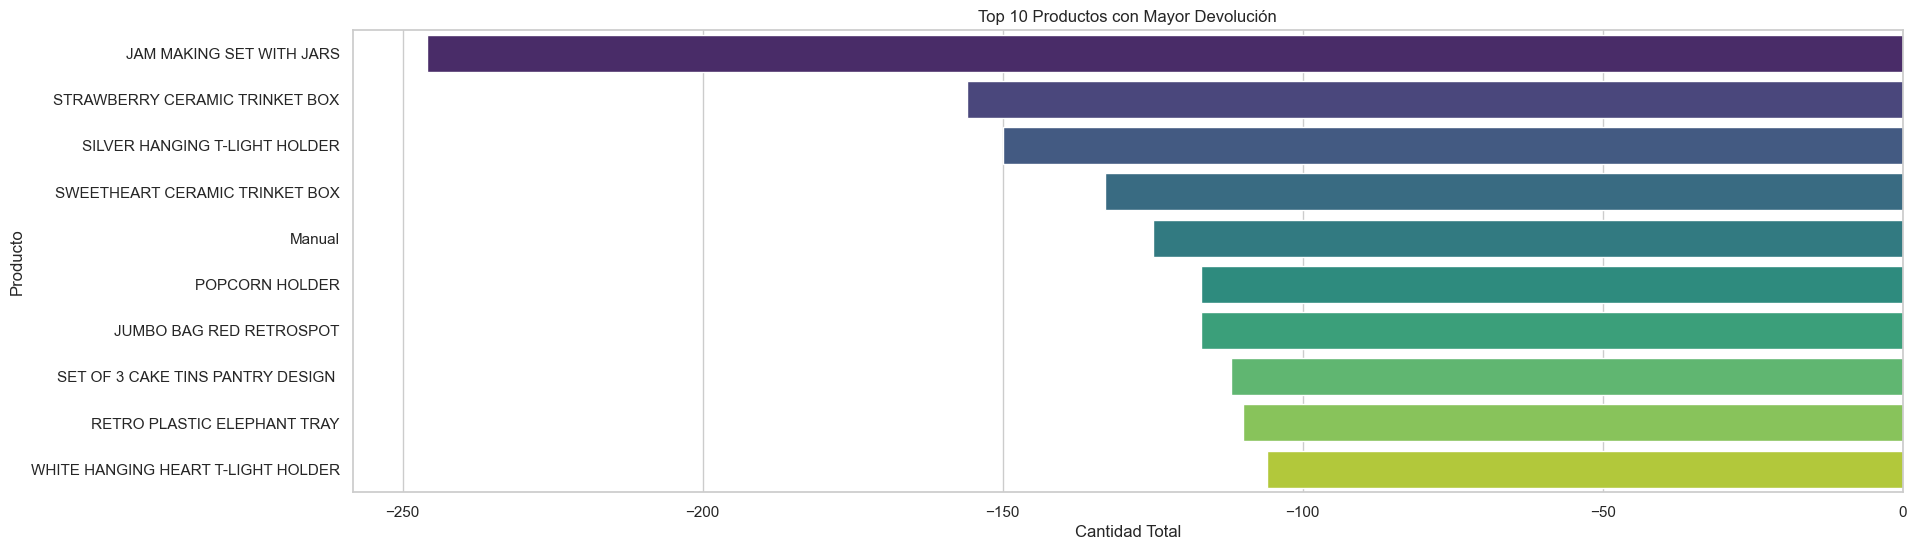

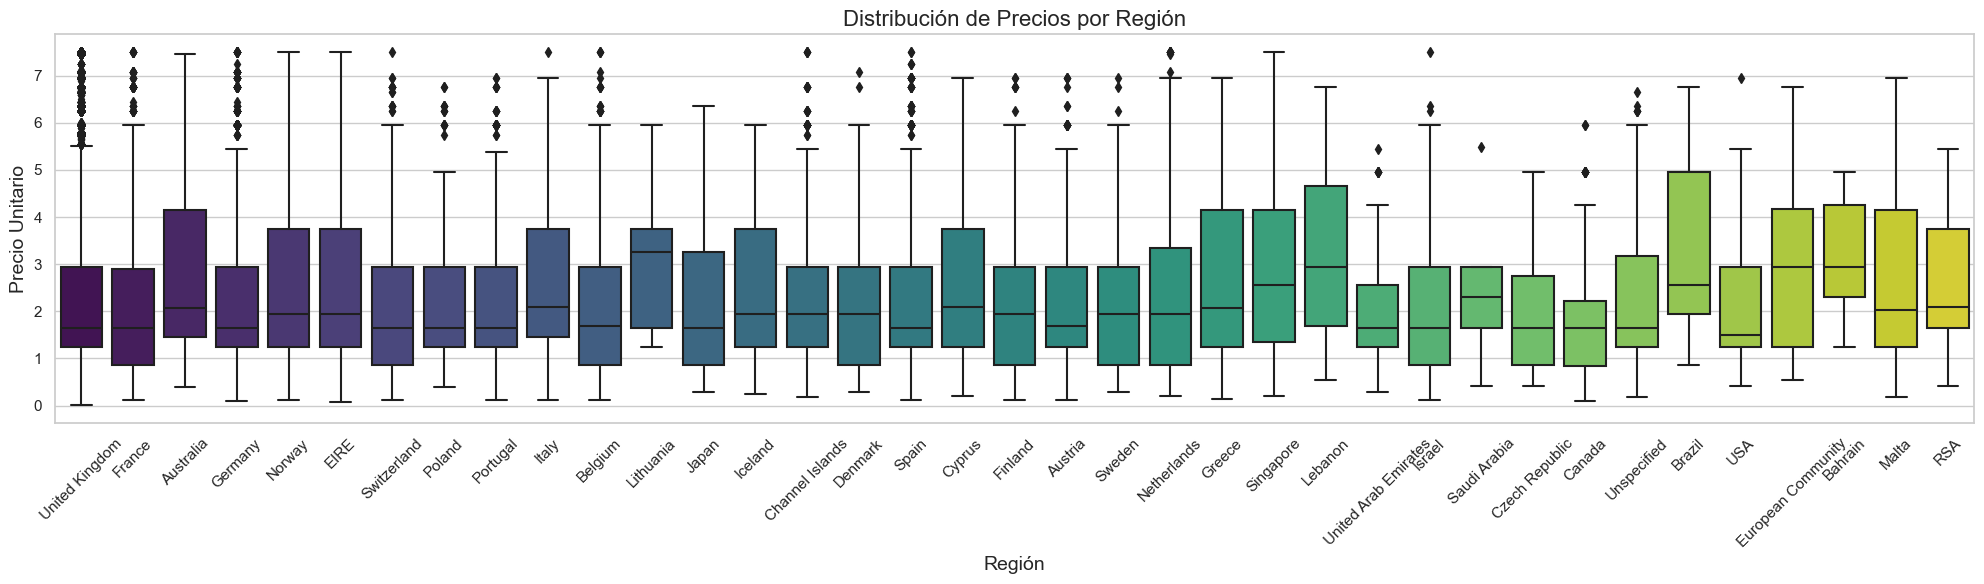

In [4]:
# Ejemplo
file_path = 'files\datasets\intermediate\df_processed.csv'
create_all_graphs(file_path)

## Conclusiones de la etapa de exploración y procesamiento de datos

***Conclusiones de los Gráficos***

- **Distribución de Precios por Región**
  - **Variabilidad de Precios**: La variación de precios por unidad entre las áreas es notable.
  - **Rango de Precios**: En la mayoría de las regiones, el rango intercuartílico oscila aproximadamente entre 1 y 4. No obstante, algunas regiones como Australia, Alemania, y Suiza tienen un rango más amplio con precios unitarios que alcanzan hasta 5 y más.
  - **Outliers**: Casi todas las regiones tienen muchos outliers, lo cual indica que algunos productos son considerablemente más caros que otros.

- **Top 10 Productos con Mayor Devolución**
  - **Principales Productos Devueltos**: Los principales productos devueltos se suman hasta “JAM MAKING SET WITH JARS”, “GUMBALL COAT RACK”, y “PLASTERS IN TIN CIRCUS PARADE”.
  - **Cantidad de Devoluciones**: Hay diferentes cantidades de devoluciones para estos productos con el mayor número que se aplica a los jam making set with jars.
  - **Impacto en el Inventario**: Cuando más grande es el número de articulos que son regresados, puede tener un impacto negativo en las existencias del inventario y sus administraciones.

- **Top 10 Productos con Mayor Compra**
  - **Productos Más Comprados**: Los productos más comprados incluyen “PACK OF 72 RETROSPOT CAKE CASES”, “PLASTERS IN TIN WOODLAND ANIMALS”, y “PLASTERS IN TIN CIRCUS PARADE”.
  - **Número de Compras**: El número total de compras de estos artículos es alto, con "PACK DE 72 CAJAS PARA PASTELES RETROSPOT" liderando con más de 3000 unidades.
  - **Popularidad del Producto**: Estos artículos son muy populares entre los clientes, lo que puede ser una indicación para abastecerse de estos productos.

- **Ventas de Mayor Volumen (Ventas Mensuales)**
  - **Temporada Alta**: Noviembre y octubre tienen las ventas más altas, probablemente debido a las compras navideñas.
  - **Variabilidad Mensual**: Las ventas varían considerablemente de un mes a otro, lo que indica la influencia de factores estacionales o promociones específicas.
  - **Planificación de Inventario**: Conocer las ventas máximas puede ayudar a planificar mejor las estrategias de inventario y marketing.

- **Precio por Unidad vs Cantidad (Precio por Unidad vs Cantidad)**
  - **Precios Bajos, Cantidades Altas**: Los productos con precios bajos tienden a venderse en grandes cantidades, por ejemplo, productos de bajo costo con alta demanda.
  - **Precios Altos, Cantidades Menores**: Los productos con precios más altos tienden a venderse menos, lo cual es típico de bienes premium o especializados.
  - **Estrategia de Precios**: Esta relación puede ayudar a identificar estrategias de precios adecuadas que maximicen tanto las ventas como los ingresos.

- **Ventas por Regiones Principales (Ventas por Región)**
  - **Mercados Principales**: Alemania y Francia son los mayores mercados en términos de volumen de ventas.
  - **Oportunidades de Expansión**: Regiones con menores ventas, como Arabia Saudita y Bahréin, podrían siginificar oportunidades para expandir a mas zonas el negocio.
  - **Estrategias Regionales**: Adaptar las estrategias de marketing y ventas a las metricas brindadas de cada región puede mejorar las ventas y la mejora en la adquisicion de cuota de mercado.

**Conclusión General**

Un mensaje general para los 6 gráficos. Los gráficos presentados proporcionan una visión general del negocio en varios frentes. Expresado en términos generales:
1. Variabilidad regional: la variabilidad en la distribución de precios unitarios entre regiones destaca una clara necesidad de precios y estrategias de marketing regional;
2. Gestión de devoluciones: Los productos con alta devolución de unidades necesitan un replanteamiento y un intento de combatir la calidad y las expectativas del cliente;
3. Productos populares: identificar y mantener un suministro constante de productos populares es vital para garantizar la satisfacción de la demanda.
4. Patrones de ventas en temporada: los picos de ventas en ciertos meses destacan la necesidad de planificación.
5. Relación Precio-Cantidad: comprender cómo funciona la relación entre el precio unitario y la cantidad vendida puede mejorar las estrategias de precios o de inventario.
6. Desempeño regional: el análisis de las ventas por región puede ayudarlo a identificar sus mercados principales y tomar decisiones de expansión.


# ML

In [17]:
def ml_kmean(path):
    # abrir archivo ya procesado
    df_processed = pd.read_csv(path)
    # seleccionar ventas
    df_ventas = df[df['transaction_type'] == 'ventas']

    # calcular rfm
    latest_date_v = df_ventas['invoice_date'].max()
    recency_df_v = df_ventas.groupby('customer_id').agg({'invoice_date': lambda x: (latest_date_v - x.max()).days})
    recency_df_v.rename(columns={'invoice_date': 'recency'}, inplace=True)
    recency_df_v = remove_outliers(recency_df_v, ['recency'])

    frequency_df_v = df_ventas.groupby('customer_id').agg({'invoice_no': 'count'})
    frequency_df_v.rename(columns={'invoice_no': 'frequency'}, inplace=True)
    frequency_df_v = remove_outliers(frequency_df_v, ['frequency'])

    monetary_df_v = df_ventas.groupby('customer_id').agg({'total_cost': 'sum'})
    monetary_df_v.rename(columns={'total_cost': 'monetary'}, inplace=True)
    monetary_df_v = remove_outliers(monetary_df_v, ['monetary'])

    # calcular rfm
    latest_date_v = df_ventas['invoice_date'].max()
    recency_df_v = df_ventas.groupby('customer_id').agg({'invoice_date': lambda x: (latest_date_v - x.max()).days})
    recency_df_v.rename(columns={'invoice_date': 'recency'}, inplace=True)
    recency_df_v = remove_outliers(recency_df_v, ['recency'])

    frequency_df_v = df_ventas.groupby('customer_id').agg({'invoice_no': 'count'})
    frequency_df_v.rename(columns={'invoice_no': 'frequency'}, inplace=True)
    frequency_df_v = remove_outliers(frequency_df_v, ['frequency'])

    monetary_df_v = df_ventas.groupby('customer_id').agg({'total_cost': 'sum'})
    monetary_df_v.rename(columns={'total_cost': 'monetary'}, inplace=True)
    monetary_df_v = remove_outliers(monetary_df_v, ['monetary'])

    #unir rfm en un archivo

    rfm_df_v = recency_df_v.join(frequency_df_v).join(monetary_df_v)
    rfm_df_v.dropna(inplace=True)

    #Método de codo

# Extraer las variables RFM en un nuevo DataFrame
    from sklearn.cluster import KMeans
    import numpy as np

    X = rfm_df_v[['recency', 'frequency', 'monetary']].values
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
        # Paso 2: Crear la línea desde el primer al último punto
    p1 = np.array([1, wcss[0]])
    p2 = np.array([10, wcss[-1]])

    # Paso 3: Calcular las distancias de cada punto a esta línea
    distances = []
    for i in range(len(wcss)):
        p = np.array([i+1, wcss[i]])
        distance = np.abs(np.cross(p2-p1, p1-p))/np.linalg.norm(p2-p1)
        distances.append(distance)

    # Paso 4: El punto con la distancia máxima es el "codo"
    n_clusters_optimo = distances.index(max(distances)) + 1

    print(f"El número óptimo de clusters es: {n_clusters_optimo}")

    # Guardar info cluster en el archivo rfm
    rfm_df_v['cluster'] = kmeans.fit_predict(X) #guardar cluster

    #renombrar clusters
    rfm_df_v['cluster'] = rfm_df_v['cluster'].replace(0, 'bronce')
    rfm_df_v['cluster'] = rfm_df_v['cluster'].replace(1, 'oro')
    rfm_df_v['cluster'] = rfm_df_v['cluster'].replace(2, 'plata')

    #archivo final
    df_final = pd.merge(df, rfm_df_v, on='customer_id', how='inner')
    df_final.to_csv('files/datasets/final/df_final.csv', index=False)


    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Subplot 1: Método del Codo
    ax[0].plot(range(1, 11), wcss, marker='o')
    ax[0].set_title('Método del Codo')
    ax[0].set_xlabel('Número de clusters')
    ax[0].set_ylabel('Inercia')

    # Subplot 2: Gráfica de los Clusters
    ax[1].remove()
    ax[1] = fig.add_subplot(1, 2, 2, projection='3d')

    # Graficar los clusters
    kmeans = KMeans(n_clusters=n_clusters_optimo).fit(X)
    centroids = kmeans.cluster_centers_
    labels = kmeans.predict(X)
    C = kmeans.cluster_centers_
    colores = ['red', 'green', 'blue']
    asignar = [colores[row] for row in labels]

    ax[1].scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar, s=60)
    ax[1].scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)
    ax[1].set_title('Visualización de Clusters')
    ax[1].set_xlabel('Recency')
    ax[1].set_ylabel('Frequency')
    ax[1].set_zlabel('Monetary')

    plt.tight_layout()
    plt.show()


In [11]:
def ml_plots(path):

    # Diagramas de caja por cluster para cada variable por cluster
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    sns.boxplot(path, x='cluster', y='recency',  hue='cluster')
    plt.subplot(1,3,2)
    sns.boxplot(path, x='cluster', y='frequency',  hue='cluster')
    plt.subplot(1,3,3)
    sns.boxplot(path, x='cluster', y='monetary',  hue='cluster')

    region_cluster_distribution = path.groupby(['region', 'cluster']).size().unstack(fill_value=0).query("region != 'United Kingdom'") ##sin UK
    top_regions = region_cluster_distribution.sum(axis=1).nlargest(10)
    top_regions_distribution = region_cluster_distribution.loc[top_regions.index]
    top_regions_distribution.plot(kind='bar', stacked=False, figsize=(15, 4))
    plt.title('Top 10 Regions')
    plt.xlabel('Region')
    plt.ylabel('Number of records')
    plt.xticks(rotation=45)
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Estadistica
    print('Recency',path.groupby('cluster')['recency'].mean().round(2))
    print('Frequency',path.groupby('cluster')['frequency'].mean().round(2))
    print('Monetary',path.groupby('cluster')['monetary'].mean().round(2))

    print('cluster oro: clientes que han comprado recientemente, compran con frecuencia y gastan mucho')
    print('cluster plata: clientes intermedios ')
    print('cluster bronce: clientes que no han comprado recientemente, compran con poca frecuencia y gastan poco')

El número óptimo de clusters es: 3


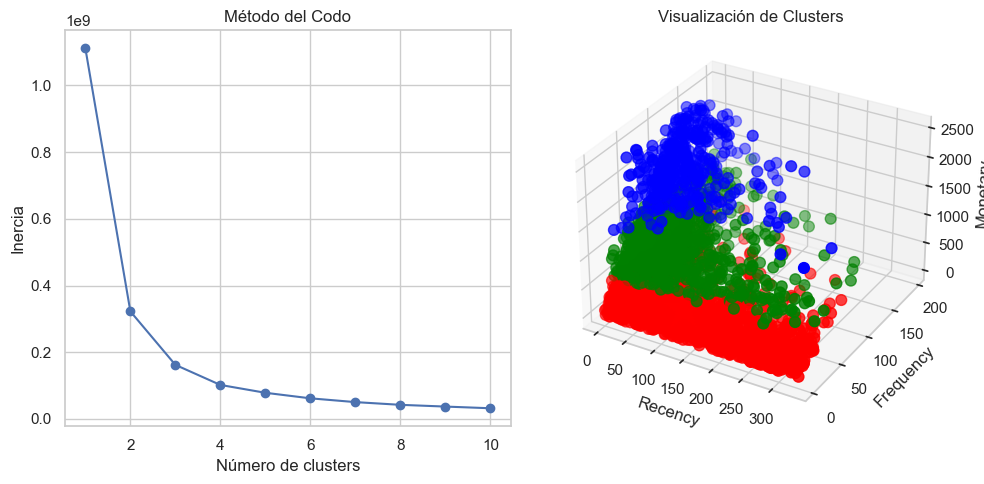

Recency cluster
3          47.97
4          63.50
5          36.80
6         235.05
7          57.16
8          48.92
9         226.17
bronce     29.77
oro        43.77
plata      48.59
Name: recency, dtype: float64
Frequency cluster
3          30.71
4          87.28
5         113.10
6          21.34
7          77.77
8          98.72
9          41.66
bronce    120.55
oro        51.97
plata      85.32
Name: frequency, dtype: float64
Monetary cluster
3          161.38
4          781.80
5         1776.64
6          136.56
7          552.56
8         1386.88
9          335.73
bronce    2210.34
oro        344.14
plata     1067.02
Name: monetary, dtype: float64
cluster oro: clientes que han comprado recientemente, compran con frecuencia y gastan mucho
cluster plata: clientes intermedios 
cluster bronce: clientes que no han comprado recientemente, compran con poca frecuencia y gastan poco


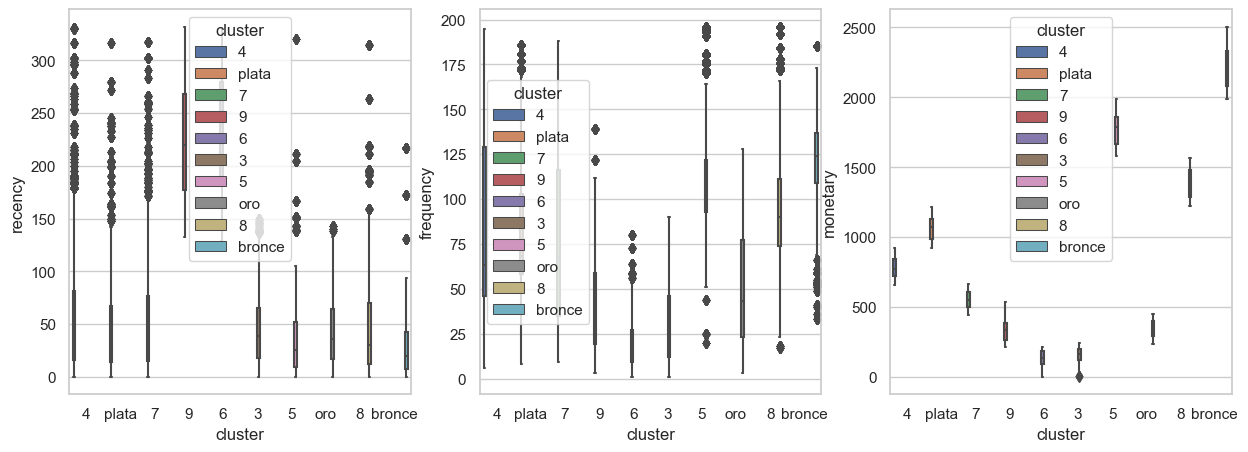

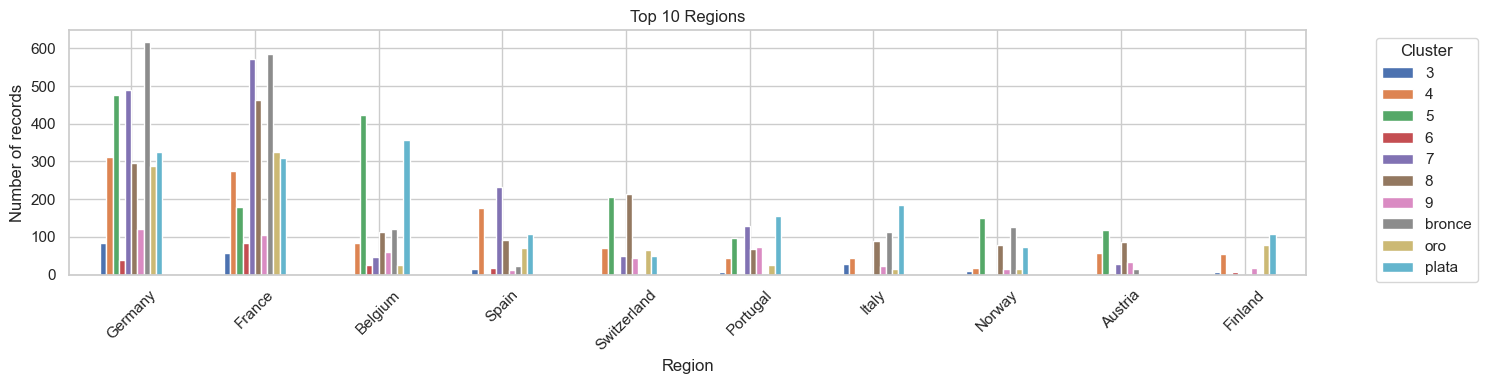

In [18]:
ml_kmean(file_path)
ml_plots(pd.read_csv("files/datasets/final/df_final.csv"))

## Conclusiones de Clustering

La metodología RFM (Recency, Frequency, Monetary) es una técnica utilizada  para segmentar y entender el comportamiento de los clientes en base a estas tres variables. Por lo anterior, se obtuvieron las métricas: Recency, Frequency y Monetary (RFM) para el conjunto de datos analizados, donde:

- Recency: Muestra la diferencia en días entre la fecha más reciente y la última compra de cada cliente.
- Frequency: Es el número de compras realizadas por cada cliente.
- Monetary: Representa el gasto total de cada cliente.

Posteriormente, estas tres nuevas variables se utilizaron para determinar el número óptimo de clusters mediante el método del codo, identificando 3 clusters óptimos. Luego, se aplicó el algoritmo K-means con este número óptimo de clusters, segmentando a los clientes en tres grupos diferenciados: oro, plata y bronce.

- Clientes oro: Clientes muy activos con compras recientes y un gasto elevado.


- Clientes plata: Clientes activos que compran frecuentemente y gasto medio.


- Clientes bronce: Clientes que realizan compras esporádicas con compras menos recientes y gasto bajo.

Esta segmentación permite a la empresa identificar y enfocar sus estrategias de marketing y retención de manera más efectiva a un grupo o a varios. Por ejemplo:

- Los clientes oro pueden recibir preventas de productos de edición limitada y nuevos lanzamientos, así como tener un servicio al cliente exclusivo.

- Los clientes plata pueden recibir ofertas de productos similares a los que compran para que aumente su gasto total.

- Los clientes bronce pueden ser incentivados con promociones para aumentar su frecuencia de compra y gasto total.
